In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam

In [2]:
# Cell 2: Load and prepare data
df = pd.read_csv('StudentFeedback_final.csv')

In [3]:
# Define protected attributes and target
protected_attribute = 'Gender'
target_column = 'What level have you achieved in the course outcomes for C01?'
feature_columns = [col for col in df.columns if col not in [protected_attribute, target_column]]

In [4]:
# Cell 3: Preprocessing class
class DataPreprocessor:
    def __init__(self):
        self.label_encoders = {}
        self.scaler = StandardScaler()
    
    def fit_transform(self, df):
        processed_df = df.copy()
        
        # Encode categorical columns
        categorical_columns = processed_df.select_dtypes(include=['object']).columns
        for col in categorical_columns:
            self.label_encoders[col] = LabelEncoder()
            processed_df[col] = self.label_encoders[col].fit_transform(processed_df[col])
        
        # Scale numerical columns
        numerical_columns = processed_df.select_dtypes(include=['float64', 'int64']).columns
        processed_df[numerical_columns] = self.scaler.fit_transform(processed_df[numerical_columns])
        
        return processed_df

In [6]:
print(df[target_column].unique())

[1.         0.83333333 0.5        0.33333333 0.66666667 0.
 0.16666667]


In [7]:
# Cell 4: Preprocess the data
preprocessor = DataPreprocessor()
processed_df = preprocessor.fit_transform(df)

# Prepare features, targets, and protected attributes
X = processed_df[feature_columns].values
y = processed_df[target_column].values
protected = processed_df[protected_attribute].values

# Convert target to one-hot encoding
num_classes = len(np.unique(y))
if num_classes > 1:
    y = keras.utils.to_categorical(y, num_classes)
else:
    print("Only one class found in target. Check your data.")

# Split the data
X_train, X_test, y_train, y_test, protected_train, protected_test = train_test_split(
    X, y, protected, test_size=0.2, random_state=42
)

In [8]:
print(y.shape)

(288, 7)


In [9]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (230, 43)
X_test shape: (58, 43)
y_train shape: (230, 7)
y_test shape: (58, 7)


In [11]:
# Cell 5: Define the Classifier model
def build_classifier(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    
    x = layers.Dense(128, activation='relu')(inputs)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs, name='classifier')
    return model

In [ ]:
# Cell 6: Define the Adversary model
def build_adversary(num_classes):
    inputs = layers.Input(shape=(num_classes,))
    x = layers.Dense(128, activation='relu')(inputs)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = Model(inputs=inputs, outputs=outputs, name='adversary')
    return model

In [27]:
 #Cell 7: Define the Combined model
class AdversarialModel(Model):
    def __init__(self, classifier, adversary):
        super(AdversarialModel, self).__init__()
        self.classifier = classifier
        self.adversary = adversary
        
    def compile(self, clf_optimizer, adv_optimizer, loss_fn, adv_loss_fn):
        super(AdversarialModel, self).compile()
        self.clf_optimizer = clf_optimizer
        self.adv_optimizer = adv_optimizer
        self.loss_fn = loss_fn
        self.adv_loss_fn = adv_loss_fn
        
    def train_step(self, data):
        # Unpack the data correctly
        X_batch, y_batch, protected_true = data  # Unpack the batch into three components
        
        y_true = y_batch  # Main task labels
        # protected_true is already extracted as the protected attribute labels
        
        # Train the adversary
        with tf.GradientTape() as tape:
            classifier_pred = self.classifier(X_batch, training=False)
            adversary_pred = self.adversary(classifier_pred, training=True)
            adv_loss = self.adv_loss_fn(protected_true, adversary_pred)
            
        adv_grad = tape.gradient(adv_loss, self.adversary.trainable_variables)
        self.adv_optimizer.apply_gradients(zip(adv_grad, self.adversary.trainable_variables))
        
        # Train the classifier
        with tf.GradientTape() as tape:
            classifier_pred = self.classifier(X_batch, training=True)
            main_loss = self.loss_fn(y_true, classifier_pred)
            
            # Add adversarial loss (negative because we want to fool the adversary)
            adversary_pred = self.adversary(classifier_pred, training=False)
            adversarial_loss = -self.adv_loss_fn(protected_true, adversary_pred)
            
            total_loss = main_loss + 0.5 * adversarial_loss
            
        clf_grad = tape.gradient(total_loss, self.classifier.trainable_variables)
        self.clf_optimizer.apply_gradients(zip(clf_grad, self.classifier.trainable_variables))
        
        return {
            "loss": total_loss,
            "main_loss": main_loss,
            "adversarial_loss": adversarial_loss
        }

In [42]:
def compute_bias_metrics(y_pred, protected_values, y_true):
    """
    Calculate bias metrics for a binary protected attribute.
    
    Args:
    y_pred (np.array): Predictions from the classifier (one-hot encoded).
    protected_values (np.array): Protected attribute values (e.g., 0 for male, 1 for female).
    y_true (np.array): True class labels (one-hot encoded).

    Returns:
    dict: A dictionary with bias metrics.
    """
    # Convert predictions and true labels from one-hot encoding to label format
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(y_true, axis=1)

    # Separate predictions by protected attribute group
    group_0_mask = protected_values == 0
    group_1_mask = protected_values == 1

    # Calculate accuracy for each group
    accuracy_group_0 = np.mean(y_pred_labels[group_0_mask] == y_true_labels[group_0_mask])
    accuracy_group_1 = np.mean(y_pred_labels[group_1_mask] == y_true_labels[group_1_mask])

    # Calculate Disparate Impact as a simple example of bias metric
    disparate_impact = accuracy_group_0 / (accuracy_group_1 + 1e-6)

    return {
        "Accuracy Group 0": accuracy_group_0,
        "Accuracy Group 1": accuracy_group_1,
        "Disparate Impact": disparate_impact
    }

In [29]:
# Cell 8: Initialize and compile the models
input_shape = (X_train.shape[1],)  # Define as a tuple to match input shape

# Build models
classifier = build_classifier(input_shape, num_classes)
adversary = build_adversary(num_classes)

# Create combined model
combined_model = AdversarialModel(classifier, adversary)

# Compile the model
combined_model.compile(
    clf_optimizer=Adam(learning_rate=0.001),
    adv_optimizer=Adam(learning_rate=0.001),
    loss_fn=tf.keras.losses.CategoricalCrossentropy(),
    adv_loss_fn=tf.keras.losses.BinaryCrossentropy()
)

In [30]:
# Cell 9: Custom Training Loop

# Prepare the data
train_dataset = tf.data.Dataset.from_tensor_slices((
    X_train,
    {
        'classifier_output': y_train,  # Main task labels (one-hot encoded)
        'adversary_output': protected_train  # Protected attribute labels
    }
)).batch(32)

# Number of epochs
epochs = 100

# Training loop
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    
    # Loop over batches
    for batch in train_dataset:
        # Unpack the batch correctly
        X_batch, y_batch = batch  # y_batch is a dictionary with keys 'classifier_output' and 'adversary_output'
        
        # Extract the labels from the dictionary
        y_true = y_batch['classifier_output']  # Main task labels
        protected_true = y_batch['adversary_output']  # Protected attribute labels
        
        # Perform one step of training
        # Call train_step manually
        result = combined_model.train_step((X_batch, y_true, protected_true))
        
        # Print loss values
        print(f"Loss: {result['loss'].numpy()}, Main Loss: {result['main_loss'].numpy()}, Adversarial Loss: {result['adversarial_loss'].numpy()}")
    
    print(f"Epoch {epoch + 1} completed.")

Epoch 1/100
Loss: 2.024256467819214, Main Loss: 2.3591792583465576, Adversarial Loss: -0.669845461845398
Loss: 1.749842643737793, Main Loss: 2.0865697860717773, Adversarial Loss: -0.6734542846679688
Loss: 1.6642346382141113, Main Loss: 1.9904662370681763, Adversarial Loss: -0.6524633169174194
Loss: 1.6805692911148071, Main Loss: 2.01362943649292, Adversarial Loss: -0.6661202907562256
Loss: 1.510807991027832, Main Loss: 1.8336372375488281, Adversarial Loss: -0.645658552646637
Loss: 1.2174263000488281, Main Loss: 1.5461044311523438, Adversarial Loss: -0.6573562622070312
Loss: 1.324349045753479, Main Loss: 1.6458942890167236, Adversarial Loss: -0.6430904269218445
Loss: 1.3998898267745972, Main Loss: 1.7165241241455078, Adversarial Loss: -0.6332686543464661
Epoch 1 completed.
Epoch 2/100
Loss: 1.0262856483459473, Main Loss: 1.3235328197479248, Adversarial Loss: -0.5944942235946655
Loss: 0.9301685094833374, Main Loss: 1.2395457029342651, Adversarial Loss: -0.6187543869018555
Loss: 1.0045628

2024-11-10 19:32:07.077970: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 0.46525681018829346, Main Loss: 0.24534428119659424, Adversarial Loss: 0.43982505798339844
Loss: 0.10952578485012054, Main Loss: 0.13611428439617157, Adversarial Loss: -0.05317699909210205
Loss: 0.40785789489746094, Main Loss: 0.22556068003177643, Adversarial Loss: 0.3645944595336914
Loss: -0.09961207211017609, Main Loss: 0.1733487993478775, Adversarial Loss: -0.5459217429161072
Loss: 0.271114706993103, Main Loss: 0.19445347785949707, Adversarial Loss: 0.15332242846488953
Loss: -0.07907421886920929, Main Loss: 0.18224330246448517, Adversarial Loss: -0.5226350426673889
Loss: 0.12317664921283722, Main Loss: 0.2318594604730606, Adversarial Loss: -0.21736562252044678
Loss: 0.033807843923568726, Main Loss: 0.17193593084812164, Adversarial Loss: -0.27625617384910583
Epoch 12 completed.
Epoch 13/100
Loss: 0.5181595087051392, Main Loss: 0.2672325670719147, Adversarial Loss: 0.5018538236618042
Loss: 0.10880618542432785, Main Loss: 0.13953018188476562, Adversarial Loss: -0.0614479929208755

2024-11-10 19:32:25.859818: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 0.23805195093154907, Main Loss: 0.08791160583496094, Adversarial Loss: 0.30028069019317627
Loss: -0.4161481261253357, Main Loss: 0.03523130714893341, Adversarial Loss: -0.9027588367462158
Loss: -0.1260446161031723, Main Loss: 0.10375028848648071, Adversarial Loss: -0.45958980917930603
Loss: -0.0013561993837356567, Main Loss: 0.1433781087398529, Adversarial Loss: -0.2894686162471771
Epoch 76 completed.
Epoch 77/100
Loss: 0.7748422622680664, Main Loss: 0.36775434017181396, Adversarial Loss: 0.8141759037971497
Loss: 0.038772374391555786, Main Loss: 0.09285907447338104, Adversarial Loss: -0.10817340016365051
Loss: 0.540266752243042, Main Loss: 0.11892984062433243, Adversarial Loss: 0.8426737785339355
Loss: -0.4663435220718384, Main Loss: 0.0681304931640625, Adversarial Loss: -1.0689480304718018
Loss: 0.2607208490371704, Main Loss: 0.046877846121788025, Adversarial Loss: 0.42768603563308716
Loss: -0.4027503430843353, Main Loss: 0.06329718232154846, Adversarial Loss: -0.932095050811767

In [43]:
# Initialize lists for tracking
total_losses = []
main_losses = []
adversarial_losses = []
bias_metrics_history = []

# Training loop
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    
    # Loop over batches
    for batch in train_dataset:
        X_batch, y_batch = batch
        y_true = y_batch['classifier_output']
        protected_true = y_batch['adversary_output']
        
        # Perform one step of training
        result = combined_model.train_step((X_batch, y_true, protected_true))
        
        # Store loss values
        total_losses.append(result['loss'].numpy())
        main_losses.append(result['main_loss'].numpy())
        adversarial_losses.append(result['adversarial_loss'].numpy())
    
    # Compute and store bias metrics at the end of each epoch
    y_pred = combined_model.classifier(X_train, training=False)
    bias_metrics = compute_bias_metrics(y_pred, protected_train, y_train)
    bias_metrics_history.append(bias_metrics)
    print(f"Epoch {epoch + 1} completed.")

Epoch 1/100


/Users/kashishvarmaa/Documents/5 Sem/DL/Bias_Mitigation/.conda/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/kashishvarmaa/Documents/5 Sem/DL/Bias_Mitigation/.conda/lib/python3.11/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch 1 completed.
Epoch 2/100


2024-11-10 20:01:47.109862: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 2 completed.
Epoch 3/100
Epoch 3 completed.
Epoch 4/100
Epoch 4 completed.
Epoch 5/100
Epoch 5 completed.
Epoch 6/100
Epoch 6 completed.
Epoch 7/100
Epoch 7 completed.
Epoch 8/100
Epoch 8 completed.
Epoch 9/100
Epoch 9 completed.
Epoch 10/100
Epoch 10 completed.
Epoch 11/100
Epoch 11 completed.
Epoch 12/100
Epoch 12 completed.
Epoch 13/100
Epoch 13 completed.
Epoch 14/100
Epoch 14 completed.
Epoch 15/100
Epoch 15 completed.
Epoch 16/100
Epoch 16 completed.
Epoch 17/100
Epoch 17 completed.
Epoch 18/100
Epoch 18 completed.
Epoch 19/100
Epoch 19 completed.
Epoch 20/100
Epoch 20 completed.
Epoch 21/100
Epoch 21 completed.
Epoch 22/100
Epoch 22 completed.
Epoch 23/100
Epoch 23 completed.
Epoch 24/100
Epoch 24 completed.
Epoch 25/100
Epoch 25 completed.
Epoch 26/100
Epoch 26 completed.
Epoch 27/100
Epoch 27 completed.
Epoch 28/100
Epoch 28 completed.
Epoch 29/100
Epoch 29 completed.
Epoch 30/100
Epoch 30 completed.
Epoch 31/100
Epoch 31 completed.
Epoch 32/100
Epoch 32 completed.
Epoch

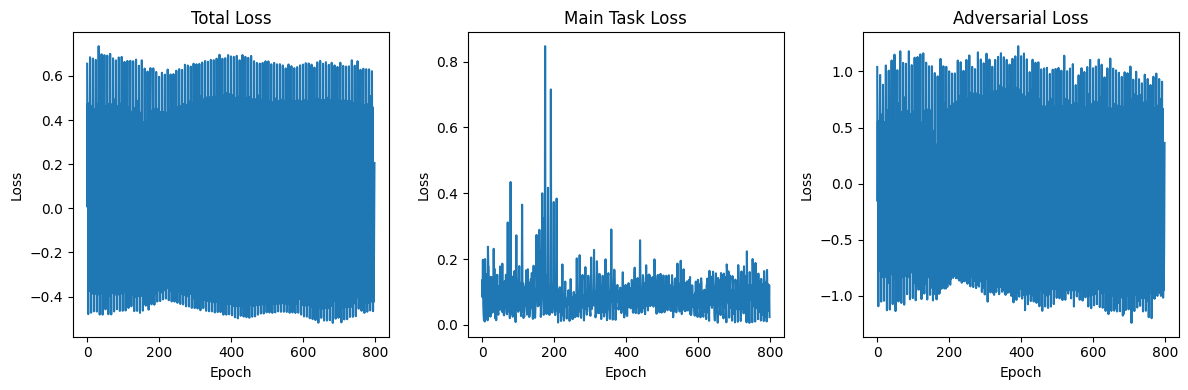

In [44]:
# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Plot total loss
plt.subplot(1, 3, 1)
plt.plot(total_losses)
plt.title('Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plot main task loss
plt.subplot(1, 3, 2)
plt.plot(main_losses)
plt.title('Main Task Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plot adversarial loss
plt.subplot(1, 3, 3)
plt.plot(adversarial_losses)
plt.title('Adversarial Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

In [45]:
# Cell 10: Evaluation functions
def calculate_bias_metrics(y_true, y_pred, protected_attributes):
    # Demographic Parity
    positive_rate_protected = np.mean(y_pred[protected_attributes == 1])
    positive_rate_unprotected = np.mean(y_pred[protected_attributes == 0])
    demographic_parity = abs(positive_rate_protected - positive_rate_unprotected)
    
    # Equal Opportunity
    true_positive_rate_protected = np.mean(y_pred[(protected_attributes == 1) & (y_true == 1)])
    true_positive_rate_unprotected = np.mean(y_pred[(protected_attributes == 0) & (y_true == 1)])
    equal_opportunity = abs(true_positive_rate_protected - true_positive_rate_unprotected)
    
    # Disparate Impact
    disparate_impact = min(
        positive_rate_protected / positive_rate_unprotected,
        positive_rate_unprotected / positive_rate_protected
    )
    
    return {
        'demographic_parity': demographic_parity,
        'equal_opportunity': equal_opportunity,
        'disparate_impact': disparate_impact
    }

Evaluating model...

Data shapes:
X_test shape: (58, 43)
y_test shape: (58, 7)
protected_test shape: (58,)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

Prediction shape: (58, 7)

Overall Performance Metrics:
Model Accuracy: 0.9483

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97        52
           6       0.71      0.83      0.77         6

    accuracy                           0.95        58
   macro avg       0.85      0.90      0.87        58
weighted avg       0.95      0.95      0.95        58


Bias Metrics:
accuracy_difference: nan
protected_accuracy: nan
unprotected_accuracy: 0.9483
demographic_parity: nan
equal_opportunity: nan


/Users/kashishvarmaa/Documents/5 Sem/DL/Bias_Mitigation/.conda/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:557: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/kashishvarmaa/Documents/5 Sem/DL/Bias_Mitigation/.conda/lib/python3.11/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/kashishvarmaa/Documents/5 Sem/DL/Bias_Mitigation/.conda/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/kashishvarmaa/Documents/5 Sem/DL/Bias_Mitigation/.conda/lib/python3.11/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


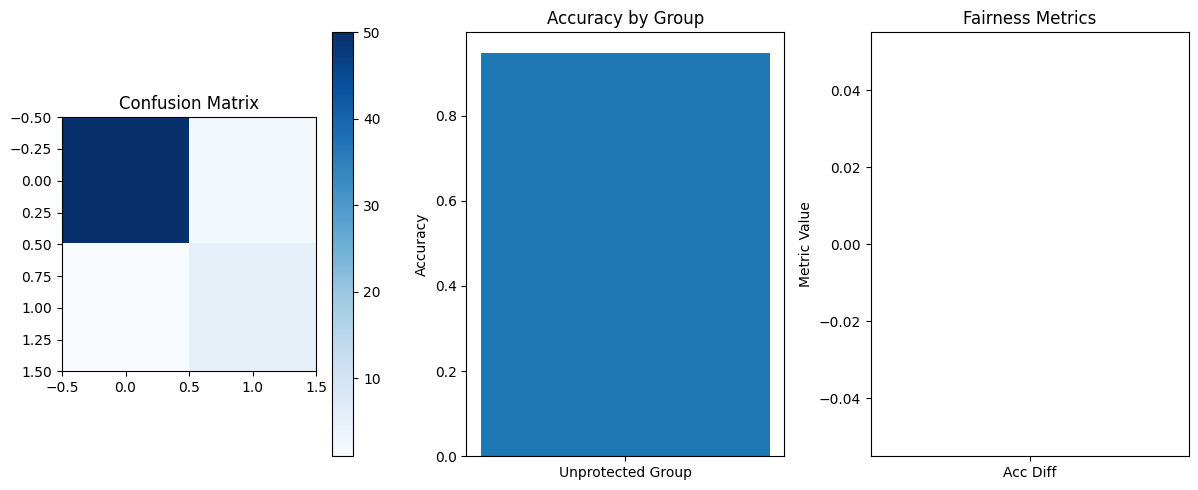

In [46]:
# Cell 11: Evaluate the model
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

def calculate_bias_metrics(y_true, y_pred, protected_attributes):
    """
    Calculate various bias metrics for the model predictions.
    
    Args:
        y_true: True labels
        y_pred: Predicted labels
        protected_attributes: Protected group attributes (binary)
    
    Returns:
        Dictionary containing various bias metrics
    """
    # Separate predictions by protected attribute
    protected_mask = protected_attributes.ravel() == 1
    unprotected_mask = ~protected_mask
    
    # Calculate accuracy for each group
    protected_acc = accuracy_score(y_true[protected_mask], y_pred[protected_mask])
    unprotected_acc = accuracy_score(y_true[unprotected_mask], y_pred[unprotected_mask])
    
    # Calculate confusion matrices for each group
    protected_cm = confusion_matrix(y_true[protected_mask], y_pred[protected_mask])
    unprotected_cm = confusion_matrix(y_true[unprotected_mask], y_pred[unprotected_mask])
    
    # Calculate true positive rates (TPR) for each group
    def calculate_tpr(cm):
        return np.diag(cm) / np.sum(cm, axis=1)
    
    protected_tpr = calculate_tpr(protected_cm)
    unprotected_tpr = calculate_tpr(unprotected_cm)
    
    # Calculate group fairness metrics
    metrics = {
        'accuracy_difference': abs(protected_acc - unprotected_acc),
        'protected_accuracy': protected_acc,
        'unprotected_accuracy': unprotected_acc,
        'demographic_parity': abs(np.mean(y_pred[protected_mask]) - np.mean(y_pred[unprotected_mask])),
        'equal_opportunity': abs(np.mean(protected_tpr) - np.mean(unprotected_tpr))
    }
    
    return metrics

try:
    print("Evaluating model...")
    print("\nData shapes:")
    print(f"X_test shape: {X_test.shape}")
    print(f"y_test shape: {y_test.shape}")
    print(f"protected_test shape: {protected_test.shape}")
    
    # Get predictions from the classifier part of the combined model
    y_pred = combined_model.classifier.predict(X_test)
    print("\nPrediction shape:", y_pred.shape)
    
    # Convert to class labels
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)
    
    # Ensure protected attributes are properly shaped
    protected_test = protected_test.ravel()
    
    # Calculate overall metrics
    accuracy = accuracy_score(y_test_classes, y_pred_classes)
    
    print("\nOverall Performance Metrics:")
    print(f"Model Accuracy: {accuracy:.4f}")
    
    # Calculate and print classification report
    print("\nDetailed Classification Report:")
    print(classification_report(y_test_classes, y_pred_classes))
    
    # Calculate bias metrics
    bias_metrics = calculate_bias_metrics(y_test_classes, y_pred_classes, protected_test)
    
    print("\nBias Metrics:")
    for metric, value in bias_metrics.items():
        print(f"{metric}: {value:.4f}")
    
    # Visualize the results
    plt.figure(figsize=(12, 5))
    
    # Plot confusion matrix
    plt.subplot(1, 3, 1)
    cm = confusion_matrix(y_test_classes, y_pred_classes)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    
    # Plot accuracy comparison
    plt.subplot(1, 3, 2)
    accuracies = [bias_metrics['protected_accuracy'], bias_metrics['unprotected_accuracy']]
    plt.bar(['Protected Group', 'Unprotected Group'], accuracies)
    plt.title('Accuracy by Group')
    plt.ylabel('Accuracy')
    
    # Plot fairness metrics
    plt.subplot(1, 3, 3)
    fairness_metrics = [bias_metrics['accuracy_difference'], 
                       bias_metrics['demographic_parity'],
                       bias_metrics['equal_opportunity']]
    plt.bar(['Acc Diff', 'Dem Parity', 'Equal Opp'], fairness_metrics)
    plt.title('Fairness Metrics')
    plt.ylabel('Metric Value')
    
    plt.tight_layout()
    plt.show()

    # Save metrics to a file
    with open('model_evaluation_results.txt', 'w') as f:
        f.write(f"Model Accuracy: {accuracy:.4f}\n\n")
        f.write("Bias Metrics:\n")
        for metric, value in bias_metrics.items():
            f.write(f"{metric}: {value:.4f}\n")
        f.write("\nClassification Report:\n")
        f.write(classification_report(y_test_classes, y_pred_classes))

except Exception as e:
    print(f"Error occurred during evaluation: {str(e)}")
    
    # Additional debugging information
    print("\nDebugging information:")
    print("Model structure:")
    print(f"Combined model type: {type(combined_model)}")
    print(f"Classifier available: {'classifier' in dir(combined_model)}")
    print("\nData information:")
    if 'X_test' in locals():
        print(f"X_test shape: {X_test.shape}")
    if 'y_test' in locals():
        print(f"y_test shape: {y_test.shape}")
    if 'protected_test' in locals():
        print(f"protected_test shape: {protected_test.shape}")

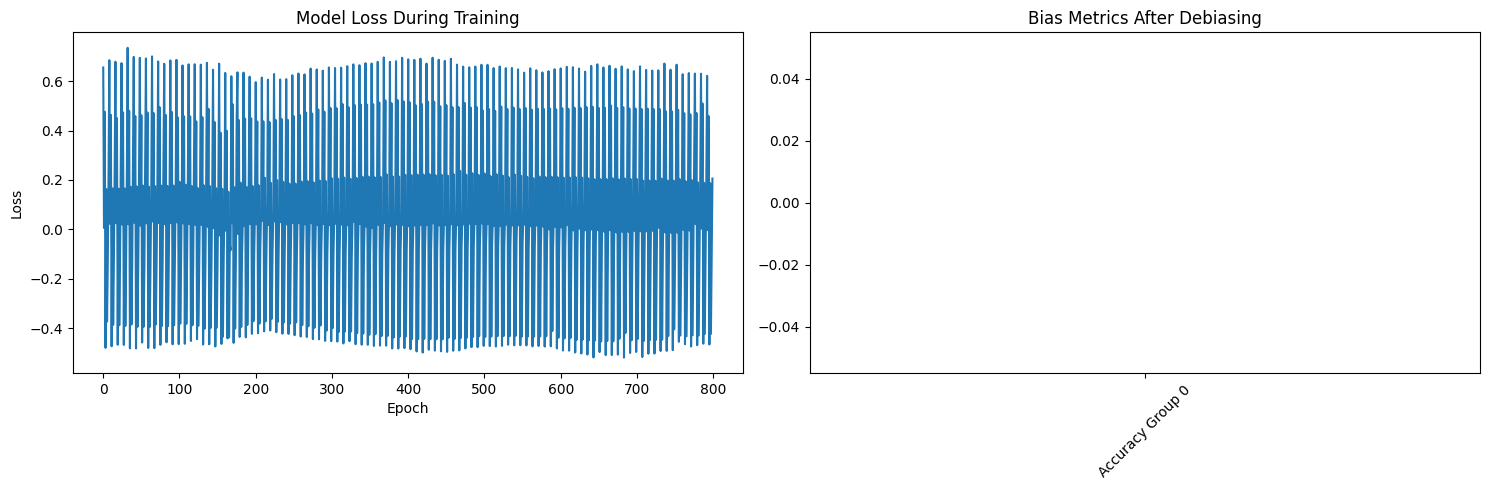

In [47]:
# Cell 12: Visualize results
plt.figure(figsize=(15, 5))

# Plot training history
plt.subplot(1, 2, 1)
plt.plot(total_losses)
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plot bias metrics
plt.subplot(1, 2, 2)
# Get average of bias metrics across epochs for visualization
avg_bias_metrics = {metric: np.mean([epoch_metrics[metric] for epoch_metrics in bias_metrics_history]) for metric in bias_metrics_history[0].keys()}

metrics = list(avg_bias_metrics.keys())
values = list(avg_bias_metrics.values())
plt.bar(metrics, values)
plt.title('Bias Metrics After Debiasing')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [48]:
# Cell 13: Analyze protected attribute predictions
adversary_predictions = adversary.predict(y_pred)
adversary_accuracy = np.mean((adversary_predictions > 0.5) == protected_test)
print(f"\nAdversary Accuracy (should be close to 0.5 for good debiasing): {adversary_accuracy:.4f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

Adversary Accuracy (should be close to 0.5 for good debiasing): 0.0000


In [49]:
# Cell 14: Save the models (optional)
classifier.save('debiased_classifier.h5')
adversary.save('adversary.h5')